# Antiderivative SpectralSVR (Proof of concept)

In [1]:
import torch
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import pandas as pd
from skripsi_program import (
    SpectralSVR,
    FourierBasis,
    StandardScaler,
    Antiderivative,
    LSSVR,
    to_real_coeff,
    to_complex_coeff,
    get_metrics,
)
from notebooks.utils import save_to_pgf

In [2]:
plt.rcParams.update(
    {
        # "text.usetex": True,  # use TeX for all texts
        "font.family": "serif",
        "font.size": 12,  # control font sizes of different elements
        # "pgf.rcfonts": False,    # don't setup fonts from rc parameters
        "figure.constrained_layout.use": True,
    }
)

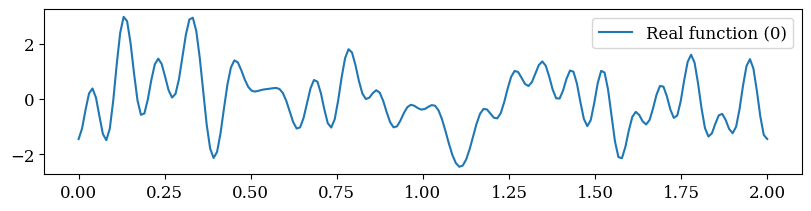

In [3]:
# Set seed
generator = torch.Generator().manual_seed(42)
# domain
domain = slice(0, 2, 500)
periods = (domain.stop - domain.start,)
# Generate functions/data
n_coeffs = 5000
modes = 50
u0 = 0  # integration constant
problem = Antiderivative()
u_clean, f_clean = problem.generate(
    FourierBasis, n_coeffs, modes, u0, generator=generator, periods=periods
)
plt.figure(figsize=(8, 2))
u_clean.plot()

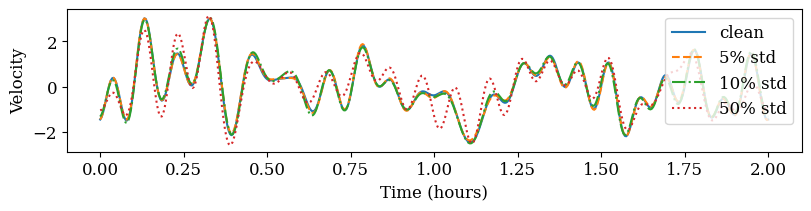

(50,)

In [4]:
# Add noise 1%
u_5 = u_clean.perturb(std_ratio=0.05, generator=generator)
f_5 = f_clean.perturb(std_ratio=0.05, generator=generator)
# Add noise 10%
u_10 = u_clean.perturb(std_ratio=0.10, generator=generator)
f_10 = f_clean.perturb(std_ratio=0.10, generator=generator)
# Add noise 50%
u_50 = u_clean.perturb(std_ratio=0.50, generator=generator)
f_50 = f_clean.perturb(std_ratio=0.50, generator=generator)


plt.figure(figsize=(8, 2))
u_clean.plot(res=domain)
u_5.plot(res=domain, linestyle="--")
u_10.plot(res=domain, linestyle="-.")
u_50.plot(res=domain, linestyle=":")
plt.xlabel("Time (hours)")
plt.ylabel("Velocity")
plt.legend(["clean", "5% std", "10% std", "50% std"], loc="upper right")
save_to_pgf("antiderivative_clean_perturbed_solution.pgf")
plt.show()
f_50.modes

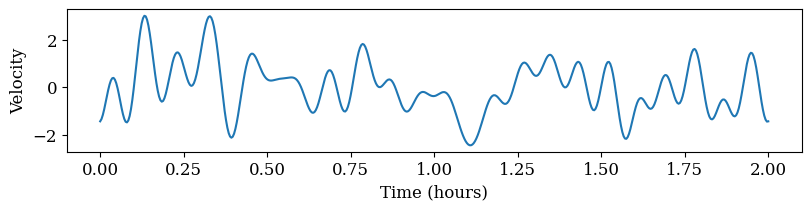

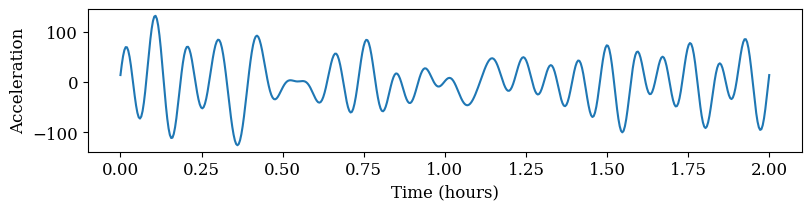

In [5]:
plt.figure(figsize=(8, 2))
u_clean.plot(i=0, res=domain, legend=False)
plt.xlabel("Time (hours)")
plt.ylabel("Velocity")
save_to_pgf("antiderivative_clean.pgf")
plt.show()
plt.figure(figsize=(8, 2))
f_clean.plot(i=0, res=domain, legend=False)
plt.xlabel("Time (hours)")
plt.ylabel("Acceleration")
save_to_pgf("antiderivative_derivative_clean.pgf")
plt.show()

In [6]:
# Train-test split
def get_preprocessed_data(f_basis: FourierBasis, u_basis: FourierBasis, train_test_ratio:tuple[float,float]=(0.8, 0.2)):
    # Interpolate f & u
    t = FourierBasis.grid(res=domain)
    f = f_basis(t)
    f = f.real

    u = u_basis(t)
    u = u.real
    # df = TensorDataset(f, u, u_fourier.coeff)
    df = TensorDataset(f, f_basis.coeff, u, u_basis.coeff)
    df_train, df_test = random_split(
        df, train_test_ratio, generator=generator
    )  # Scale inputs based on training inputs
    f_train, f_coeff_train, u_train, u_coeff_train = df_train[:]
    # f_input_train = f_train
    f_input_train = f_coeff_train
    scaler = StandardScaler().fit(f_input_train)
    f_input_train = scaler.transform(f_input_train)
    f_test, f_coeff_test, u_test, u_coeff_test = df_test[:]
    # f_input_test = f_test
    f_input_test = f_coeff_test
    f_input_test = scaler.transform(f_input_test)

    return f_input_train, u_coeff_train, f_input_test, u_coeff_test, df_train, df_test, scaler


In [7]:
# Exact problem
def get_exact_basis():
    t = torch.linspace(domain.start, domain.stop, modes)
    derivative = 2 * torch.pi * torch.cos(2 * torch.pi * t)
    solution = torch.sin(2 * torch.pi * t)
    derivative_coeff = FourierBasis.transform(derivative.unsqueeze(0))
    solution_coeff = FourierBasis.transform(solution.unsqueeze(0))
    return FourierBasis(derivative_coeff, periods=periods), FourierBasis(
        solution_coeff, periods=periods
    )
f_exact, u_exact = get_exact_basis()

In [8]:
f_exact_5 = f_exact.perturb(0.05, generator=generator)
f_exact_10 = f_exact.perturb(0.1, generator=generator)
f_exact_50 = f_exact.perturb(0.5, generator=generator)

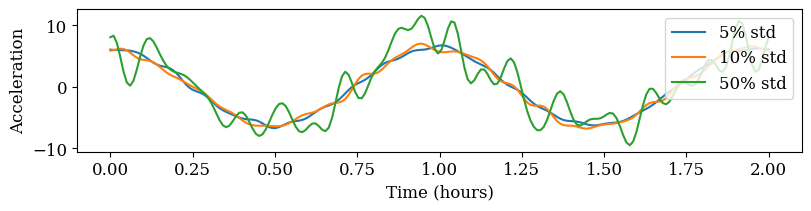

In [9]:
plt.figure(figsize=(8, 2))
f_exact_5.plot()
f_exact_10.plot()
f_exact_50.plot()
# u_exact.plot()
plt.xlabel("Time (hours)")
plt.ylabel("Acceleration")
plt.legend(["5% std", "10% std", "50% std", "target"], loc="upper right")
save_to_pgf("antiderivative_exact_input.pgf")

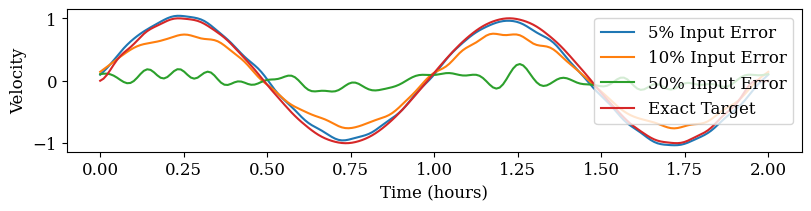

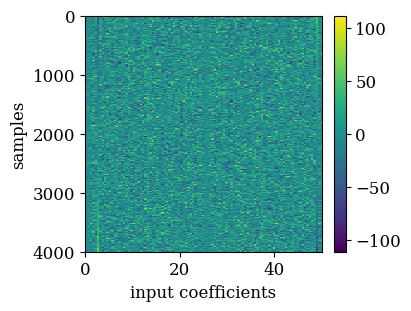

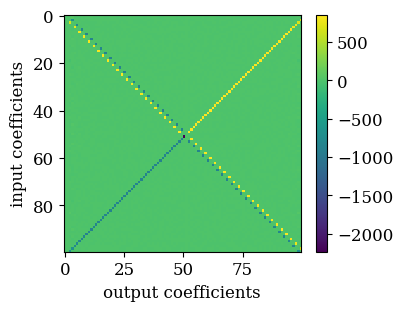

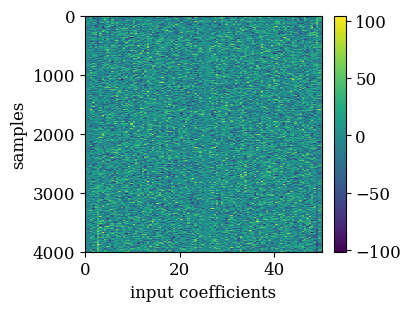

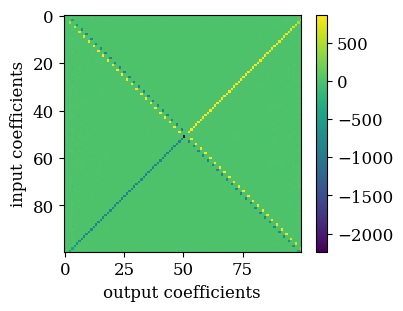

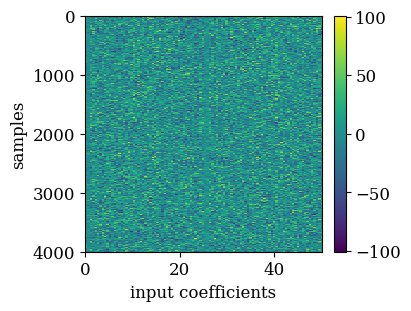

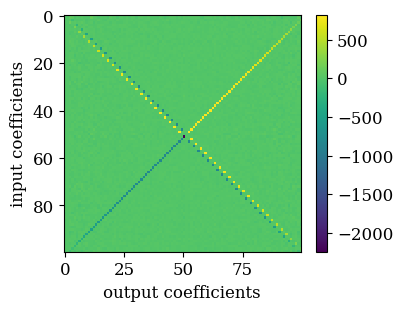

In [ ]:
# Train svm
sets = [
    (f_5, u_5, f_exact_5, u_exact),
    (f_10, u_10, f_exact_10, u_exact),
    (f_50, u_50, f_exact_50, u_exact),
]
spectral_results = {}
function_results = {}
clean_spectral_results = {}
clean_function_results = {}
exact_spectral_results = {}
exact_function_results = {}
inv_spectral_results = {}
legend = []
exact_fig, exact_ax = plt.subplots(figsize=(8, 2))
interp_fig = []
interp_ax = []
for i, (percentage, data) in enumerate(zip(["5", "10", "50"], sets)):
    f, u, input_exact, output_exact = data
    input_train, output_train, input_test, output_test, df_train, df_test, scaler = (
        get_preprocessed_data(f, u)
    )
    model = SpectralSVR(
        FourierBasis(periods=periods),
        svr=LSSVR(
            C=1.0,
            device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
        ),
        verbose=None,
    )
    model.train(input_train, output_train)
    sigma = model.svr.kernel_params.get("sigma")
    assert isinstance(sigma, torch.Tensor), "Make sure the kernel is RBF"
    sigma = sigma.cpu().item()

    metrics = model.test(input_test, output_test)
    percentage_label = f"{percentage}%"
    spectral_results = {
        **spectral_results,
        percentage_label: {
            "sigma": sigma,
            **metrics["spectral"],
        },
    }
    function_results = {
        **function_results,
        percentage_label: {
            "sigma": sigma,
            **metrics["function value"],
        },
    }
    clean_metrics = model.test(input_test, u_clean.coeff[df_test.indices])
    clean_spectral_results = {
        **clean_spectral_results,
        percentage_label: {
            **clean_metrics["spectral"],
        },
    }
    clean_function_results = {
        **clean_function_results,
        percentage_label: {
            **clean_metrics["function value"],
        },
    }

    # Exact problem
    exact_input = scaler.transform(input_exact.coeff)
    exact_metrics = model.test(exact_input, output_exact.coeff)
    exact_spectral_results = {
        **exact_spectral_results,
        percentage_label: {
            **exact_metrics["spectral"],
        },
    }
    exact_function_results = {
        **exact_function_results,
        percentage_label: {
            **exact_metrics["function value"],
        },
    }
    pred_exact = FourierBasis(
        to_complex_coeff(model.svr.predict(to_real_coeff(exact_input))), periods=periods
    )
    pred_exact.plot(plt=exact_ax)
    legend = [*legend, f"{percentage_label} Input Error"]
    # inverse problem
    inv_pred = model.inverse_coeff(
        output_test, epochs=2000, lr=1e-2, generator=generator
    )
    inv_metrics = get_metrics(
        to_real_coeff(scaler.inverse(inv_pred)),
        to_real_coeff(scaler.inverse(input_test)),
    )
    inv_spectral_results = {**inv_spectral_results, percentage_label: {**inv_metrics}}

    # interpretations
    tmp_fig, tmp_ax = plt.subplots(figsize=(4, 3))
    interp_fig.append(tmp_fig)
    interp_ax.append(tmp_ax)
    fig_index = 2 * i
    corr = model.svr.get_correlation_image().cpu()
    sorted = output_train.real[:, 2].sort()
    im = interp_ax[fig_index].imshow(
        corr[sorted.indices.cpu(), :],
        interpolation="none",
        aspect="auto",
        extent=(0, modes, corr.shape[0], 0),
    )
    interp_ax[fig_index].set_ylabel("samples")
    interp_ax[fig_index].set_xlabel("input coefficients")
    interp_fig[fig_index].colorbar(im, ax=interp_ax[fig_index])
    save_to_pgf(f"antiderivative_ci_{percentage}.pgf", plt=interp_fig[fig_index])

    tmp_fig, tmp_ax = plt.subplots(figsize=(4, 3))
    interp_fig.append(tmp_fig)
    interp_ax.append(tmp_ax)
    fig_index = 2 * i + 1
    p_mat = model.svr.get_p_matrix().cpu()
    im = interp_ax[fig_index].imshow(p_mat[:, :], interpolation="none", aspect="equal")
    # plt.imshow(p_mat[:,2][:,None], interpolation="none", aspect="auto", extent=(0,10,0,10))
    interp_ax[fig_index].set_xlabel("output coefficients")
    interp_ax[fig_index].set_ylabel("input coefficients")
    interp_fig[fig_index].colorbar(im, ax=interp_ax[2 * i + 1])
    save_to_pgf(f"antiderivative_pm_{percentage}.pgf", plt=interp_fig[fig_index])

u_exact.plot(plt=exact_ax)
exact_ax.legend([*legend, "Exact Target"])
exact_ax.set_xlabel("Time (hours)")
exact_ax.set_ylabel("Velocity")
save_to_pgf("antiderivative_exact_prediction.pgf", plt=exact_fig)
# exact_fig

In [11]:
function_results

{'5%': {'sigma': 10.001250267028809,
  'mse': 0.03412556275725365,
  'rmse': 0.18473105132579803,
  'mae': 0.14638951420783997,
  'r2': 0.9650756120681763,
  'smape': 0.39009037613868713,
  'rse': 0.034924402832984924,
  'rrse': 0.18680213391780853,
  'pred_nan_sum': 0},
 '10%': {'sigma': 10.001250267028809,
  'mse': 0.08202524483203888,
  'rmse': 0.2864004969596863,
  'mae': 0.22853371500968933,
  'r2': 0.9166046977043152,
  'smape': 0.5509830117225647,
  'rse': 0.0833953395485878,
  'rrse': 0.288666695356369,
  'pred_nan_sum': 0},
 '50%': {'sigma': 10.001250267028809,
  'mse': 0.6211560964584351,
  'rmse': 0.7881345748901367,
  'mae': 0.6283995509147644,
  'r2': 0.49202507734298706,
  'smape': 1.0481492280960083,
  'rse': 0.5079749226570129,
  'rrse': 0.7125607132911682,
  'pred_nan_sum': 0}}

In [11]:
spectral_results_df = pd.DataFrame(spectral_results).T
spectral_results_df.index.name="Noise level"
spectral_results_df.style.format(precision=2).to_latex("tmp.tex")

In [16]:
function_results_df = pd.DataFrame(function_results).T
function_results_df.index.name="Noise level"
function_results_df.style.format(precision=2).to_latex("tmp.tex")

In [17]:
clean_spectral_results_df = pd.DataFrame(clean_spectral_results).T
clean_spectral_results_df.index.name="Noise level"
clean_spectral_results_df.style.format(precision=2).to_latex("tmp.tex")

In [19]:
clean_function_results_df = pd.DataFrame(clean_function_results).T
clean_function_results_df.index.name="Noise level"
clean_function_results_df.style.format(precision=2).to_latex("tmp.tex")

In [12]:
exact_spectral_results_df = pd.DataFrame(exact_spectral_results).T
exact_spectral_results_df.index.name="Noise level"
exact_spectral_results_df.style.format(precision=2).to_latex("tmp.tex")

In [13]:
exact_function_results_df = pd.DataFrame(exact_function_results).T
exact_function_results_df.index.name="Noise level"
exact_function_results_df.style.format(precision=2).to_latex("tmp.tex")

In [11]:
inv_spectral_results_df = pd.DataFrame(inv_spectral_results).T
inv_spectral_results_df.index.name="Noise level"
inv_spectral_results_df.style.format(precision=2).to_latex("tmp.tex")

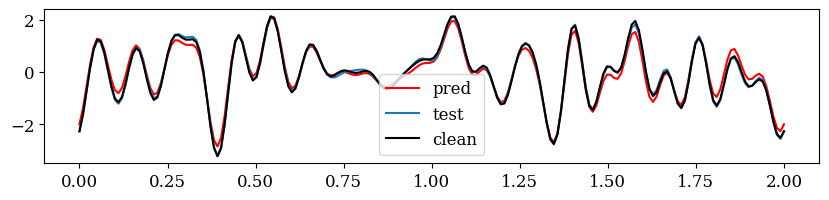

In [20]:
input_train, output_train, input_test, output_test, df_train, df_test, scaler = (
    get_preprocessed_data(f_5, u_5)
)
model = SpectralSVR(
    FourierBasis(periods=periods),
    svr=LSSVR(
        C=1.0,
        device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    ),
    verbose=None,
)
model.train(input_train, output_train)
sigma = model.svr.kernel_params.get("sigma")
assert isinstance(sigma, torch.Tensor), "Make sure the kernel is RBF"
sigma = sigma.cpu().item()

metrics = model.test(input_test, output_test)
clean_metrics = model.test(input_test, u_clean.coeff[df_test.indices])
u_pred = model.svr.predict(to_real_coeff(input_test))
output_test = to_real_coeff(u_clean[df_test.indices].coeff)

u_pred = FourierBasis(to_complex_coeff(u_pred), periods=periods)
plt.figure(figsize=(8, 2))
i = 2
u_pred[i].plot(color="r")
u_5[df_test.indices[i]].plot()
u_clean[df_test.indices[i]].plot(color="k")
plt.legend(["pred", "test", "clean"])
# save_to_pgf("")
plt.show()

In [ ]:
inv_pred = to_complex_coeff(model.inverse_coeff(output_test,epochs=2000,lr=1e-2,))
inv_pred = scaler.inverse(inv_pred)
inv = model.basis.copy()
inv.coeff = inv_pred
# inv_metrics = get_metrics(to_real_coeff(inv_pred), to_real_coeff(input_test))
# inv_spectral_results = {**inv_spectral_results, percentage_label: {**inv_metrics}}

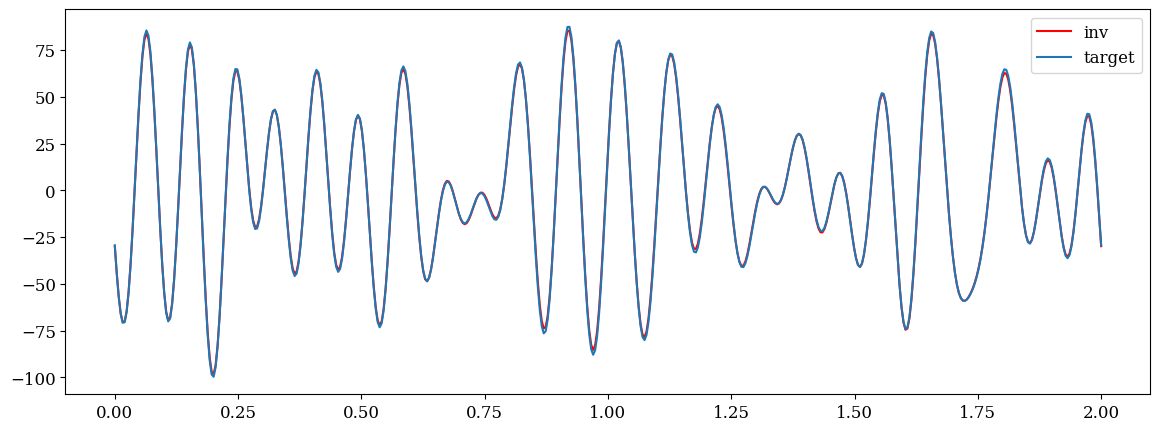

In [28]:
plt.figure(figsize=(8, 2))
inv.plot(i=3, c="r", res=500)
f_clean[df_test.indices].plot(i=3, res=500)
plt.legend(["inverse prediction", "target"])
save_to_pgf("antiderivative_inverse.pgf")

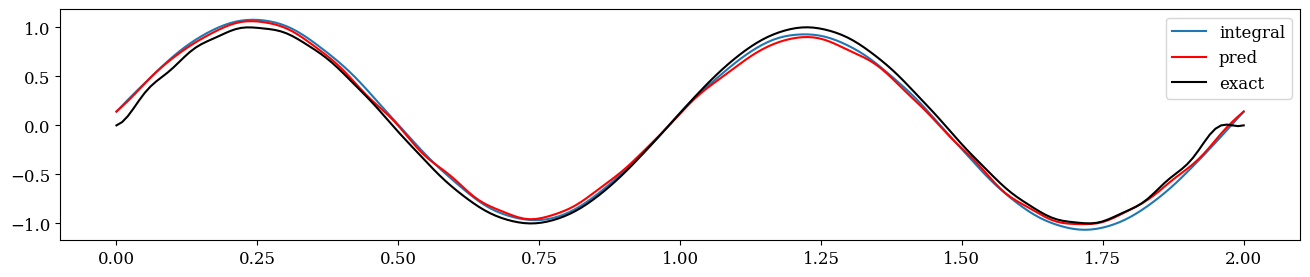

In [51]:
exact_input = to_real_coeff(scaler.transform(f_exact_5.coeff))
u_pred = FourierBasis(to_complex_coeff(model.svr.predict(exact_input)), periods=periods)
plt.figure(figsize=(8, 2))
# f_single.plot()
f_exact_5.integral().plot()
u_pred.plot(color="r")
u_exact.plot(color="k")
plt.legend(["integral", "pred", "exact"])
# save_to_pgf("")
plt.show()

In [28]:
u_pred.coeff.shape

torch.Size([1, 50])

In [27]:
u_exact.coeff.shape

torch.Size([1, 50])

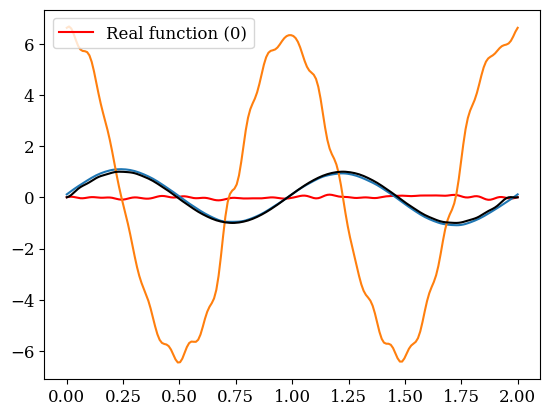

In [24]:
u_pred.plot(color="r")
f_exact_5.integral().plot()
f_exact_5.plot()
u_exact.plot(color="k")

(torch.Size([4000, 100]),
 torch.return_types.sort(
 values=tensor([-17.2997, -17.0102, -15.3124,  ...,  16.1155,  17.2215,  17.5983]),
 indices=tensor([ 871, 1221, 2454,  ...,  479, 1742,  179])))

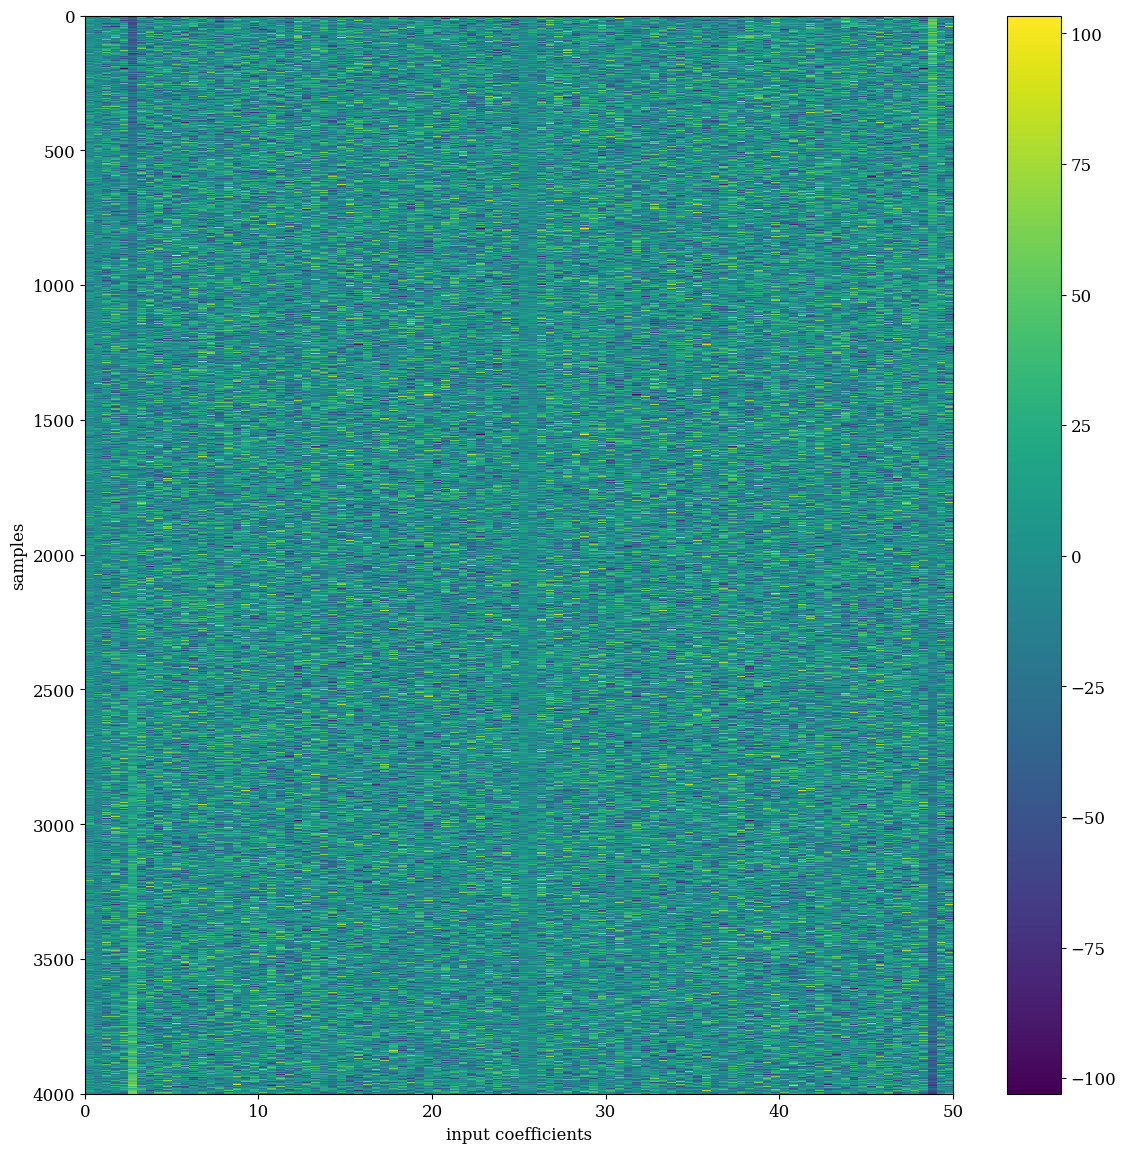

In [15]:
corr = model.svr.get_correlation_image().cpu()
sorted = output_train.real[:,2].sort()
plt.figure(figsize=(8, 8))
plt.imshow(corr[sorted.indices.cpu(), :], interpolation="none", aspect="auto",extent=(0,modes,corr.shape[0],0))
plt.ylabel("samples")
plt.xlabel("input coefficients")
plt.colorbar()
corr.shape, sorted


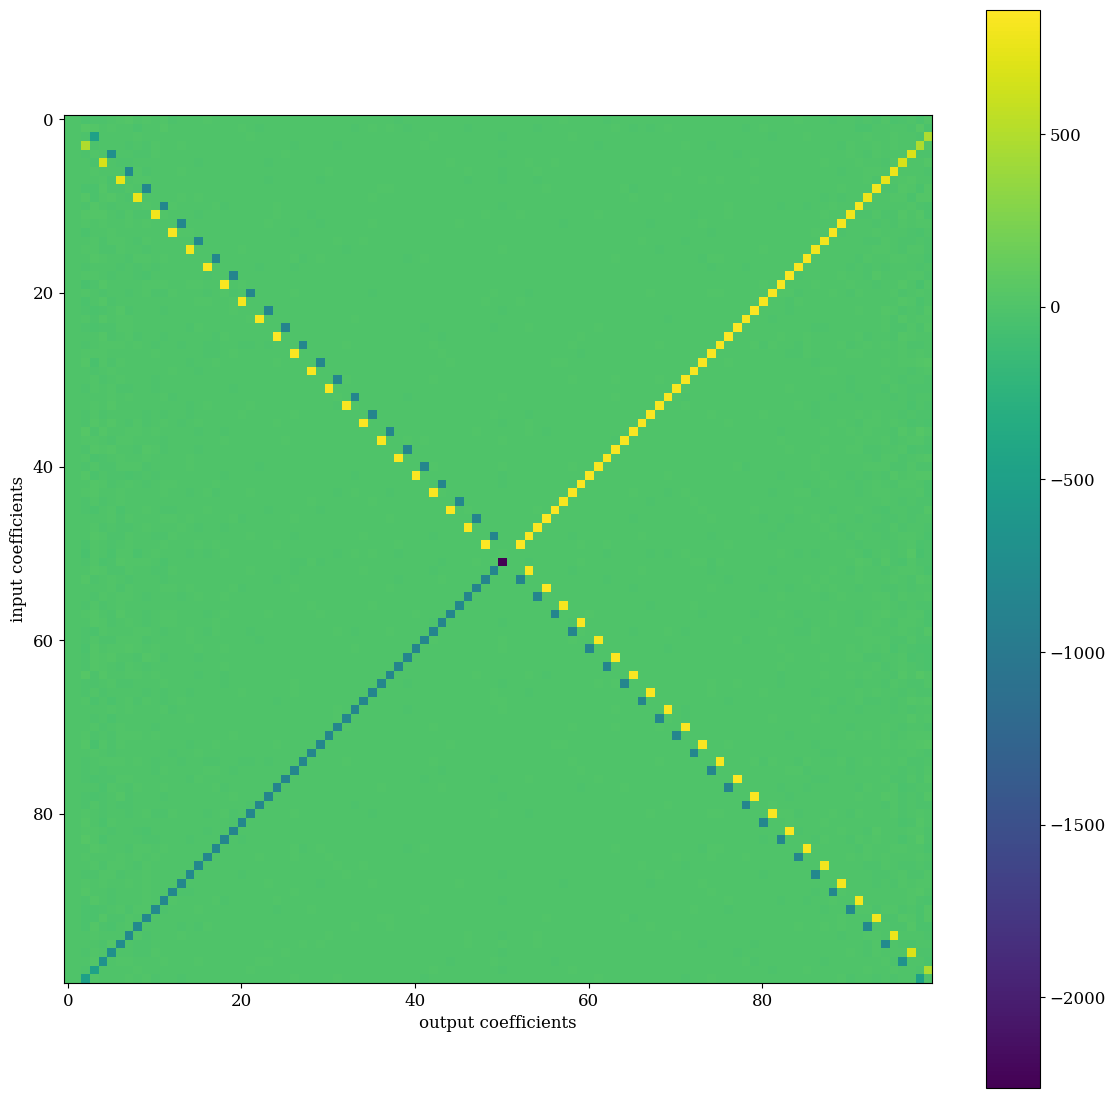

In [16]:
p_mat = model.svr.get_p_matrix().cpu()
plt.figure(figsize=(8, 8))
plt.imshow(p_mat[:, :], interpolation="none", aspect="equal")
# plt.imshow(p_mat[:,2][:,None], interpolation="none", aspect="auto", extent=(0,10,0,10))
plt.colorbar()
plt.xlabel("output coefficients")
plt.ylabel("input coefficients")
plt.show()

In [17]:
u_clean[0].coeff, u_clean[0].grad().coeff

(tensor([[ 0.0000+0.0000e+00j,  5.9584-7.5454e+00j, -6.4740-6.0901e+00j,
           4.5666-7.3829e+00j, -8.7484+8.7557e+00j, -5.0980-7.0976e+00j,
           0.0568-2.7523e-01j,  1.3165+2.5131e+00j,  7.7022-2.4191e+00j,
          -6.4986+3.6238e+00j, -2.6420+5.0101e+00j, -4.9695+8.5964e+00j,
           6.5553+6.8524e+00j,  2.3585+3.2118e+00j, -1.4277-1.7042e+00j,
          -4.6180-1.4783e+00j, -3.6700-2.3826e+00j,  7.0524+4.2221e+00j,
           6.2367-4.5288e+00j, -3.1071-7.6302e+00j, -5.8527-3.0015e+00j,
          -3.3349-4.5140e+00j, -9.4660+7.3779e+00j, -7.2431+8.7709e-01j,
          -4.9562-6.5390e+00j,  0.5517+1.4901e-07j, -4.9562+6.5390e+00j,
          -7.2431-8.7709e-01j, -9.4660-7.3779e+00j, -3.3349+4.5140e+00j,
          -5.8527+3.0015e+00j, -3.1071+7.6302e+00j,  6.2367+4.5288e+00j,
           7.0524-4.2221e+00j, -3.6700+2.3826e+00j, -4.6180+1.4783e+00j,
          -1.4277+1.7042e+00j,  2.3585-3.2118e+00j,  6.5553-6.8524e+00j,
          -4.9695-8.5964e+00j, -2.6420-5.0101e+00j,

In [19]:
# Test CPU
model = SpectralSVR(
    FourierBasis(periods=periods),
    svr=LSSVR(
        C=1.0,
        device=torch.device("cpu"),
    ),
    verbose=None,
)
%timeit model.train(f_train, u_coeff_train)
%timeit model.test(f_test,u_coeff_test)

1.41 s ± 171 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
57 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
# Test GPU
model = SpectralSVR(
    FourierBasis(periods=periods),
    svr=LSSVR(
        C=1.0,
        device=torch.device("cuda:0"),
    ),
    verbose=None,
)
%timeit model.train(f_train, u_coeff_train)
%timeit model.test(f_test,u_coeff_test)

149 ms ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.3 ms ± 432 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
